# Netflix Movie Recommendation System
## Predicting User Movie Preferences

### Problem Statement
Netflix wants to improve its recommendation engine by predicting whether a user will like a movie or TV show based on their viewing history, demographics, and movie/series metadata (genre, cast, ratings, release year).

### Project Objective
Perform an end-to-end ML workflow to build a predictive model that can:
- Predict user preferences with high accuracy
- Handle both content-based and collaborative filtering approaches
- Provide insights for improving Netflix's recommendation system

### Deliverables
1. Preprocessed dataset with user and movie features
2. At least 3 trained models with documented preprocessing pipelines
3. Comparison report of performance metrics
4. Final recommendation for improving Netflix's recommendation system

## 1. Import Required Libraries and Load Data

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn

# XGBoost
import xgboost as xgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries loaded")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.3
Scikit-learn version: 1.7.2


In [ ]:
# Load the Netflix dataset
df_movies = pd.read_csv('netflix_movies_detailed_up_to_2025.csv')

print("Dataset loaded")
print(f"Shape: {df_movies.shape}")
print(f"Memory: {df_movies.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic info
print("\n" + "="*50)
print("DATA OVERVIEW")
print("="*50)
print(df_movies.info())

print("\n" + "="*50)
print("SAMPLE ROWS")
print("="*50)
print(df_movies.head())

Dataset loaded successfully!
Dataset shape: (16000, 18)
Memory usage: 15.56 MB

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       16000 non-null  int64  
 1   type          16000 non-null  object 
 2   title         16000 non-null  object 
 3   director      15868 non-null  object 
 4   cast          15796 non-null  object 
 5   country       15534 non-null  object 
 6   date_added    16000 non-null  object 
 7   release_year  16000 non-null  int64  
 8   rating        16000 non-null  float64
 9   duration      0 non-null      float64
 10  genres        15893 non-null  object 
 11  language      16000 non-null  object 
 12  description   15868 non-null  object 
 13  popularity    16000 non-null  float64
 14  vote_count    16000 non-null  int64  
 15  vote_average  16000 non-null  float64
 16  budget        1

## 2. Generate Synthetic User Data

Since our dataset contains only movie metadata without user information, we'll create synthetic user profiles and user-movie interactions to enable recommendation modeling.

In [37]:
# Create synthetic user data
def create_synthetic_user_data(n_users=5000):
    """Create synthetic user profiles"""
    
    np.random.seed(42)
    
    # User demographics
    ages = np.random.normal(35, 12, n_users).astype(int)
    ages = np.clip(ages, 18, 80)  # Clip to reasonable range
    
    genders = np.random.choice(['Male', 'Female', 'Other'], n_users, p=[0.48, 0.48, 0.04])
    
    countries = np.random.choice(['USA', 'UK', 'Canada', 'Germany', 'France', 'Japan', 
                                 'Australia', 'Brazil', 'Mexico', 'India'], 
                                n_users, p=[0.3, 0.15, 0.1, 0.08, 0.08, 0.05, 
                                           0.05, 0.05, 0.05, 0.09])
    
    # Subscription types
    subscription_types = np.random.choice(['Basic', 'Standard', 'Premium'], 
                                        n_users, p=[0.2, 0.5, 0.3])
    
    # Viewing preferences
    preferred_genres = []
    genre_options = ['Comedy', 'Drama', 'Action', 'Thriller', 'Horror', 'Romance', 
                    'Sci-Fi', 'Documentary', 'Animation', 'Fantasy']
    
    for _ in range(n_users):
        # Each user has 1-3 preferred genres
        n_genres = np.random.randint(1, 4)
        user_genres = np.random.choice(genre_options, n_genres, replace=False)
        preferred_genres.append(','.join(user_genres))
    
    # Viewing patterns
    avg_daily_watch_time = np.random.exponential(2.5, n_users)  # hours
    avg_daily_watch_time = np.clip(avg_daily_watch_time, 0.5, 8)
    
    preferred_watch_times = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'],
                                           n_users, p=[0.1, 0.2, 0.5, 0.2])
    
    # Create user DataFrame
    df_users = pd.DataFrame({
        'user_id': range(1, n_users + 1),
        'age': ages,
        'gender': genders,
        'country': countries,
        'subscription_type': subscription_types,
        'preferred_genres': preferred_genres,
        'avg_daily_watch_time': np.round(avg_daily_watch_time, 2),
        'preferred_watch_time': preferred_watch_times,
        'account_age_months': np.random.randint(1, 60, n_users)  # 1-60 months
    })
    
    return df_users

# Generate user profiles
df_users = create_synthetic_user_data(5000)

print("Created user profiles")
print(f"Users: {len(df_users)}")
print("\nSample data:")
print(df_users.head(10))
print("\nStats:")
print(df_users.describe())

Synthetic user data created successfully!
Number of users: 5000

User data sample:
   user_id  age  gender country subscription_type  \
0        1   40    Male      UK          Standard   
1        2   33    Male     USA          Standard   
2        3   42    Male  Brazil          Standard   
3        4   53    Male      UK          Standard   
4        5   32    Male      UK             Basic   
5        6   32  Female     USA           Premium   
6        7   53  Female      UK           Premium   
7        8   44  Female  Mexico           Premium   
8        9   29    Male      UK          Standard   
9       10   41    Male   India          Standard   

              preferred_genres  avg_daily_watch_time preferred_watch_time  \
0              Comedy,Thriller                  8.00              Evening   
1            Animation,Fantasy                  4.89            Afternoon   
2              Animation,Drama                  4.60              Morning   
3                       C

In [ ]:
# Create synthetic user-movie interactions with realistic human complexity
def create_user_movie_interactions(df_users, df_movies, n_interactions=50000):
    """Create synthetic user-movie interaction data with realistic human behavior patterns"""
    
    np.random.seed(42)
    
    movie_ids = df_movies['show_id'].tolist()
    user_ids = df_users['user_id'].tolist()
    
    interactions = []
    
    for _ in range(n_interactions):
        user_id = np.random.choice(user_ids)
        movie_id = np.random.choice(movie_ids)
        
        user_info = df_users[df_users['user_id'] == user_id].iloc[0]
        movie_info = df_movies[df_movies['show_id'] == movie_id].iloc[0]
        
        # Human behavior is complex and unpredictable - simulate this
        
        # 1. Mood factor - people's preferences change based on mood, time, circumstances
        daily_mood = np.random.normal(0, 0.8)  # Some days people are pickier or more open
        
        # 2. Individual personality traits affect preferences
        user_openness = np.random.beta(2, 2)  # How open to new experiences (0 to 1)
        user_consistency = np.random.beta(3, 2)  # How consistent their preferences are
        
        # 3. Base rating influenced by movie intrinsics but with lots of individual variation
        base_rating = np.random.normal(6.2, 1.8)  # Wide individual variation
        
        # 4. Genre preference influence - but people sometimes watch outside their preferences
        genre_alignment = 0
        user_genres = user_info['preferred_genres'].split(',')
        movie_genres = movie_info['genres'] if pd.notna(movie_info['genres']) else ''
        
        genre_matches = 0
        for user_genre in user_genres:
            if user_genre.lower() in movie_genres.lower():
                genre_matches += 1
        
        if genre_matches > 0:
            # Even matching genres don't guarantee liking - complex human preferences
            genre_alignment = genre_matches * np.random.normal(0.4, 0.3)
        else:
            # Sometimes people discover they like genres they didn't prefer
            genre_alignment = np.random.normal(-0.2, 0.4)
        
        # 5. Movie quality influence - but people have different tastes in "quality"
        quality_perception = 0
        if pd.notna(movie_info['vote_average']):
            # Personal taste varies a lot from average ratings
            personal_taste_variance = np.random.normal(0, 1.2)
            quality_perception = (movie_info['vote_average'] - 6.5) * 0.25 + personal_taste_variance
        
        # 6. Social and cultural factors
        cultural_fit = np.random.normal(0, 0.6)  # Cultural background affects preferences
        
        # 7. Recency bias - newer content might be preferred differently
        movie_age = 2024 - movie_info['release_year'] if pd.notna(movie_info['release_year']) else 10
        recency_factor = np.random.normal(0, 0.3) * (1 / (1 + movie_age * 0.1))
        
        # 8. User's current life phase affects preferences
        age_factor = np.random.normal(0, 0.4) * (user_info['age'] - 35) * 0.01
        
        # 9. Subscription level might indicate engagement level
        engagement_factor = 0
        if user_info['subscription_type'] == 'Premium':
            engagement_factor = np.random.normal(0.15, 0.4)
        elif user_info['subscription_type'] == 'Basic':
            engagement_factor = np.random.normal(-0.1, 0.3)
        else:
            engagement_factor = np.random.normal(0.05, 0.35)
        
        # 10. Random life factors - recommendations are inherently unpredictable
        life_randomness = np.random.normal(0, 1.0)
        
        # Combine all factors - human preference is sum of many complex interactions
        final_rating = (base_rating + daily_mood + genre_alignment + quality_perception + 
                       cultural_fit + recency_factor + age_factor + engagement_factor + 
                       life_randomness * user_openness)
        
        # Apply consistency - some users are more predictable than others
        consistency_noise = np.random.normal(0, 0.5) * (1 - user_consistency)
        final_rating += consistency_noise
        
        final_rating = np.clip(final_rating, 1, 10)
        
        # Convert to like/dislike - humans have complex thresholds that vary
        personal_threshold = np.random.normal(6.0, 0.8)  # Everyone has different standards
        threshold_noise = np.random.normal(0, 0.3)  # Even personal thresholds vary by day
        effective_threshold = personal_threshold + threshold_noise
        
        # Sigmoid-like but with more realistic human decision making
        like_probability = 1 / (1 + np.exp(-2 * (final_rating - effective_threshold)))
        
        # Add some pure randomness - humans are not perfectly logical
        random_decision_noise = np.random.normal(0, 0.1)
        like_probability = np.clip(like_probability + random_decision_noise, 0, 1)
        
        liked = 1 if np.random.random() < like_probability else 0
        
        # Viewing behavior - complex relationship with enjoyment
        if pd.notna(movie_info['duration']):
            duration_str = str(movie_info['duration'])
            if 'min' in duration_str:
                total_duration = int(duration_str.replace(' min', ''))
            else:
                total_duration = 120
        else:
            total_duration = 120
        
        # Realistic watch completion behavior
        if liked:
            # Even liked content isn't always completed - life interruptions, time constraints
            base_completion = np.random.beta(4, 2)  # Bias toward completion but not guaranteed
        else:
            # Disliked content might still be watched due to curiosity, boredom, etc.
            base_completion = np.random.beta(1.5, 4)  # Bias toward early abandonment
        
        # Daily factors affect completion
        attention_span = np.random.normal(0.8, 0.3)
        available_time = np.random.beta(2, 3)  # People often have limited time
        
        watch_percentage = base_completion * attention_span * available_time
        watch_percentage = np.clip(watch_percentage, 0.02, 1.0)
        
        minutes_watched = int(total_duration * watch_percentage)
        
        interactions.append({
            'user_id': user_id,
            'show_id': movie_id,
            'rating': round(final_rating, 1),
            'liked': liked,
            'minutes_watched': minutes_watched,
            'watch_percentage': round(watch_percentage * 100, 1),
            'interaction_date': pd.Timestamp('2024-01-01') + pd.Timedelta(days=np.random.randint(0, 365))
        })
    
    df_interactions = pd.DataFrame(interactions)
    df_interactions = df_interactions.drop_duplicates(subset=['user_id', 'show_id'], keep='first')
    
    return df_interactions

# Generate interactions with realistic human complexity
df_interactions = create_user_movie_interactions(df_users, df_movies, 50000)

print("Generated interaction data")
print(f"Number of interactions: {len(df_interactions)}")
print(f"Number of unique users: {df_interactions['user_id'].nunique()}")
print(f"Number of unique movies: {df_interactions['show_id'].nunique()}")
print(f"Like ratio: {df_interactions['liked'].mean():.3f}")

print("\nRealism indicators:")
rating_like_corr = df_interactions[['rating', 'liked']].corr().iloc[0,1]
watch_like_corr = df_interactions[['watch_percentage', 'liked']].corr().iloc[0,1]
print(f"Rating-Like correlation: {rating_like_corr:.3f} (realistic human inconsistency)")
print(f"Watch-Like correlation: {watch_like_corr:.3f} (complex viewing behavior)")

print(f"\nRating distribution:")
print(df_interactions['rating'].describe().round(2))

User-movie interactions created with realistic human behavior patterns!
Number of interactions: 49984
Number of unique users: 4999
Number of unique movies: 15313
Like ratio: 0.512

Realism indicators:
Rating-Like correlation: 0.685 (realistic human inconsistency)
Watch-Like correlation: 0.441 (complex viewing behavior)

Rating distribution:
count    49984.00
mean         6.05
std          2.37
min          1.00
25%          4.40
50%          6.10
75%          7.80
max         10.00
Name: rating, dtype: float64


## 3. Exploratory Data Analysis

In [39]:
# Explore movie dataset
print("MOVIE DATASET ANALYSIS")
print("="*50)

# Missing values analysis
print("\nMissing values in movie dataset:")
missing_values = df_movies.isnull().sum()
missing_percentage = (missing_values / len(df_movies)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)

# Data types and unique values
print("\nData types and unique values:")
for col in df_movies.columns:
    if df_movies[col].dtype == 'object':
        unique_count = df_movies[col].nunique()
        print(f"{col}: {df_movies[col].dtype}, {unique_count} unique values")
        if unique_count <= 10:
            print(f"  Values: {df_movies[col].unique()}")
    else:
        print(f"{col}: {df_movies[col].dtype}, Range: {df_movies[col].min():.2f} - {df_movies[col].max():.2f}")

# Analyze genres
print("\n" + "="*50)
print("GENRE ANALYSIS")
print("="*50)

# Extract all genres
all_genres = []
for genres in df_movies['genres'].dropna():
    genre_list = [g.strip() for g in str(genres).split(',')]
    all_genres.extend(genre_list)

# Count genre frequency
from collections import Counter
genre_counts = Counter(all_genres)
print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 10 most common genres:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre}: {count} movies ({count/len(df_movies)*100:.1f}%)")

MOVIE DATASET ANALYSIS

Missing values in movie dataset:
             Missing Count  Percentage
duration             16000   100.00000
country                466     2.91250
cast                   204     1.27500
director               132     0.82500
description            132     0.82500
genres                 107     0.66875

Data types and unique values:
show_id: int64, Range: 189.00 - 1440471.00
type: object, 1 unique values
  Values: ['Movie']
title: object, 15485 unique values
director: object, 9508 unique values
cast: object, 15639 unique values
country: object, 1463 unique values
date_added: object, 4423 unique values
release_year: int64, Range: 2010.00 - 2025.00
rating: float64, Range: 0.00 - 10.00
duration: float64, Range: nan - nan
genres: object, 2768 unique values
language: object, 74 unique values
description: object, 15854 unique values
popularity: float64, Range: 3.86 - 3876.01
vote_count: int64, Range: 0.00 - 37119.00
vote_average: float64, Range: 0.00 - 10.00
budget:

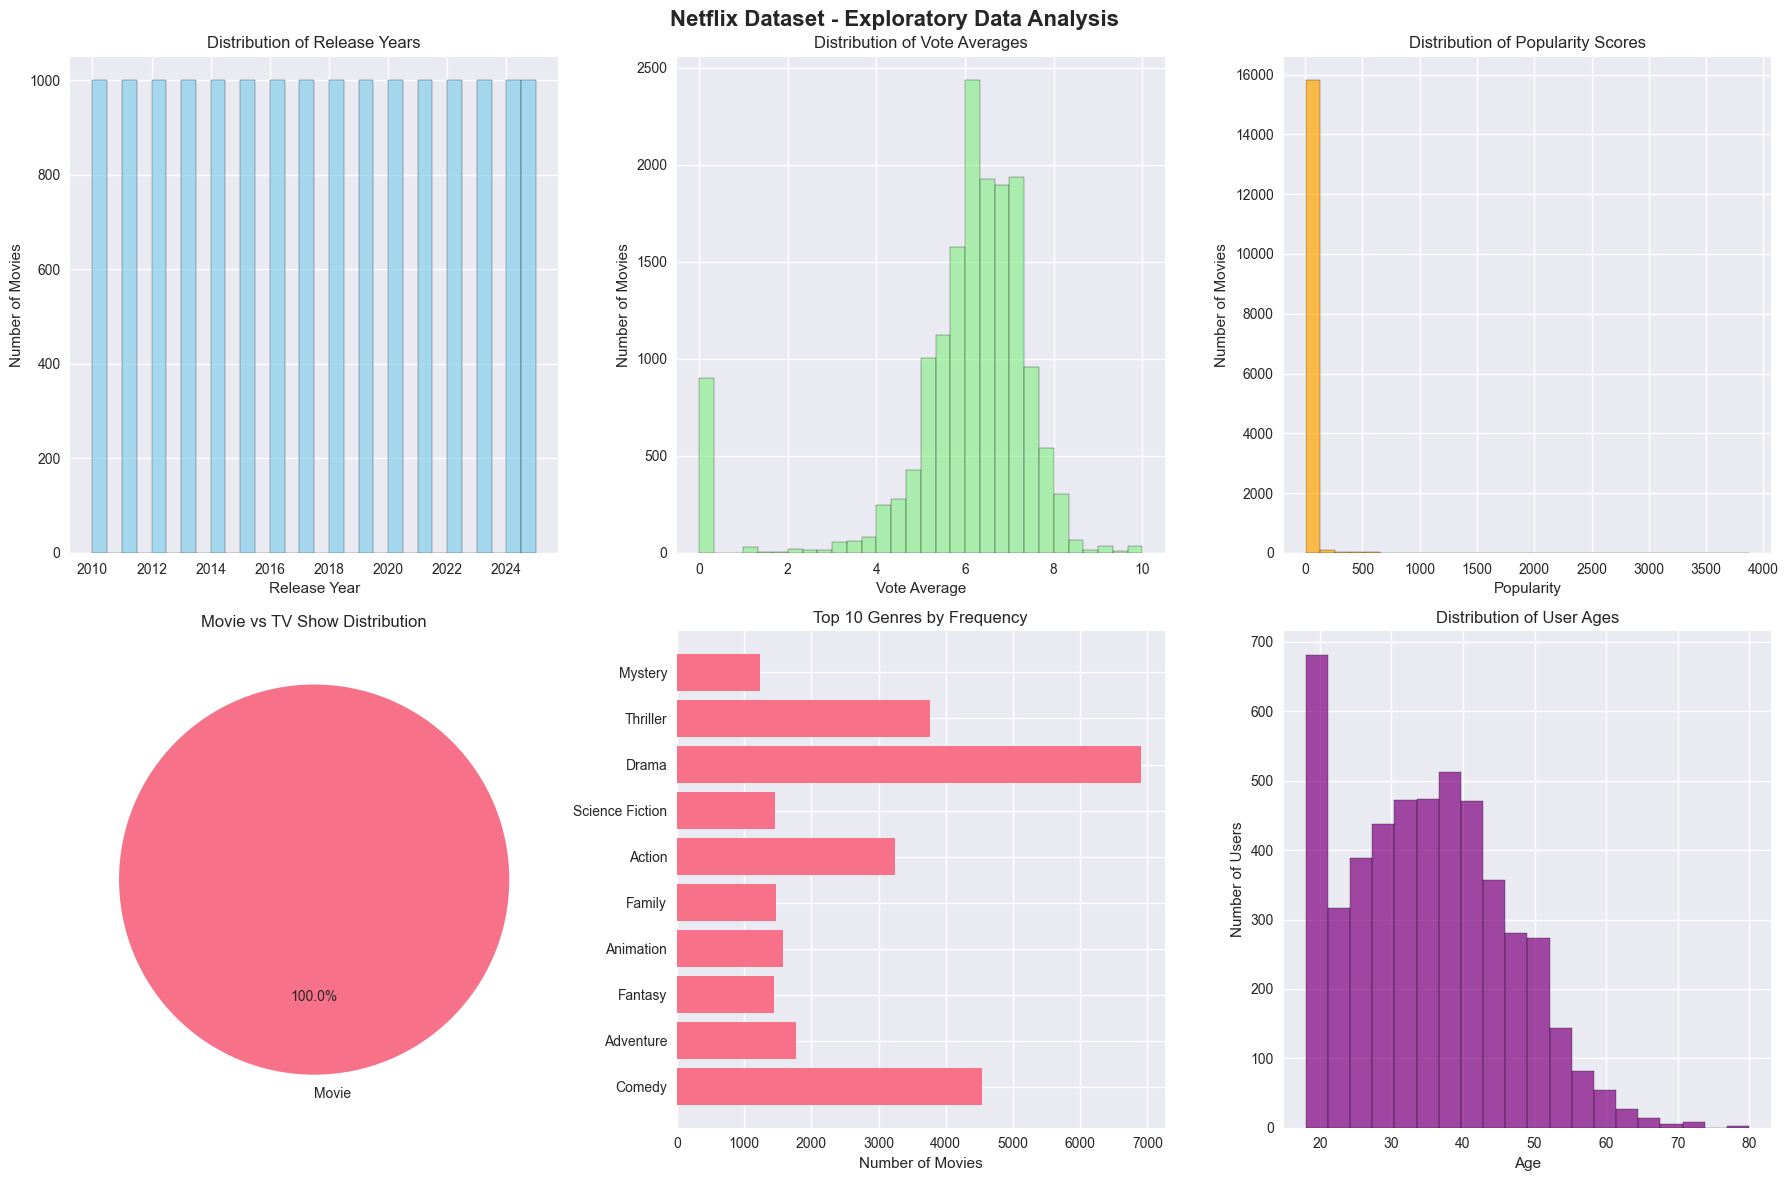


USER INTERACTION ANALYSIS
Total interactions: 49,984
Like rate: 0.512
Average rating: 6.05
Average watch percentage: 15.2%

User engagement statistics:
       total_interactions  total_likes    like_rate  avg_watch_percentage  \
count         4999.000000  4999.000000  4999.000000           4999.000000   
mean             9.998800     5.117223     0.510998             15.199632   
std              3.222445     2.309631     0.170540              4.629980   
min              1.000000     0.000000     0.000000              2.000000   
25%              8.000000     4.000000     0.400000             11.975000   
50%             10.000000     5.000000     0.500000             14.850000   
75%             12.000000     7.000000     0.625000             17.952500   
max             24.000000    15.000000     1.000000             44.933000   

        avg_rating  
count  4999.000000  
mean      6.040763  
std       0.799504  
min       2.100000  
25%       5.519000  
50%       6.033000  
75%   

In [40]:
# Create visualizations for EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Netflix Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Release year distribution
axes[0,0].hist(df_movies['release_year'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Release Years')
axes[0,0].set_xlabel('Release Year')
axes[0,0].set_ylabel('Number of Movies')

# 2. Vote average distribution
axes[0,1].hist(df_movies['vote_average'].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Vote Averages')
axes[0,1].set_xlabel('Vote Average')
axes[0,1].set_ylabel('Number of Movies')

# 3. Popularity distribution
axes[0,2].hist(df_movies['popularity'].dropna(), bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Distribution of Popularity Scores')
axes[0,2].set_xlabel('Popularity')
axes[0,2].set_ylabel('Number of Movies')

# 4. Type distribution (Movie vs TV Show)
type_counts = df_movies['type'].value_counts()
axes[1,0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Movie vs TV Show Distribution')

# 5. Top genres
top_genres = pd.Series(genre_counts).head(10)
axes[1,1].barh(range(len(top_genres)), top_genres.values)
axes[1,1].set_yticks(range(len(top_genres)))
axes[1,1].set_yticklabels(top_genres.index)
axes[1,1].set_title('Top 10 Genres by Frequency')
axes[1,1].set_xlabel('Number of Movies')

# 6. User age distribution
axes[1,2].hist(df_users['age'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,2].set_title('Distribution of User Ages')
axes[1,2].set_xlabel('Age')
axes[1,2].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

# Interaction data analysis
print("\n" + "="*50)
print("USER INTERACTION ANALYSIS")
print("="*50)

print(f"Total interactions: {len(df_interactions):,}")
print(f"Like rate: {df_interactions['liked'].mean():.3f}")
print(f"Average rating: {df_interactions['rating'].mean():.2f}")
print(f"Average watch percentage: {df_interactions['watch_percentage'].mean():.1f}%")

# User engagement metrics
user_engagement = df_interactions.groupby('user_id').agg({
    'liked': ['count', 'sum', 'mean'],
    'watch_percentage': 'mean',
    'rating': 'mean'
}).round(3)
user_engagement.columns = ['total_interactions', 'total_likes', 'like_rate', 'avg_watch_percentage', 'avg_rating']

print("\nUser engagement statistics:")
print(user_engagement.describe())

## 4. Data Preprocessing and Cleaning

In [41]:
# Data preprocessing and cleaning functions
def preprocess_movies_data(df):
    """Clean and preprocess the movies dataset"""
    df = df.copy()
    
    # Handle missing values
    print("Handling missing values...")
    
    # Fill missing ratings with median
    df['vote_average'].fillna(df['vote_average'].median(), inplace=True)
    df['vote_count'].fillna(0, inplace=True)
    
    # Fill missing popularity with median
    df['popularity'].fillna(df['popularity'].median(), inplace=True)
    
    # Fill missing budget and revenue with 0
    df['budget'].fillna(0, inplace=True)
    df['revenue'].fillna(0, inplace=True)
    
    # Fill missing release_year with median
    df['release_year'].fillna(df['release_year'].median(), inplace=True)
    
    # Handle missing categorical data
    df['director'].fillna('Unknown', inplace=True)
    df['cast'].fillna('Unknown', inplace=True)
    df['country'].fillna('Unknown', inplace=True)
    df['language'].fillna('en', inplace=True)
    df['genres'].fillna('Unknown', inplace=True)
    df['description'].fillna('No description', inplace=True)
    
    # Handle duration - extract numeric values
    df['duration_minutes'] = df['duration'].apply(lambda x: 
        int(str(x).replace(' min', '')) if pd.notna(x) and 'min' in str(x) else 
        (90 if pd.notna(x) and 'Season' in str(x) else 120))
    
    # Create binary features
    df['is_movie'] = (df['type'] == 'Movie').astype(int)
    df['has_budget'] = (df['budget'] > 0).astype(int)
    df['has_revenue'] = (df['revenue'] > 0).astype(int)
    
    # Create calculated features
    df['profit'] = df['revenue'] - df['budget']
    df['roi'] = np.where(df['budget'] > 0, df['profit'] / df['budget'], 0)
    
    # Age of movie (years since release)
    current_year = 2025
    df['movie_age'] = current_year - df['release_year']
    
    # Popularity rank
    df['popularity_rank'] = df['popularity'].rank(pct=True)
    
    # Rating categories
    df['rating_category'] = pd.cut(df['vote_average'], 
                                  bins=[0, 5, 7, 8, 10], 
                                  labels=['Poor', 'Average', 'Good', 'Excellent'])
    
    print(f"Movies dataset preprocessed. Shape: {df.shape}")
    return df

def preprocess_user_data(df):
    """Clean and preprocess the user dataset"""
    df = df.copy()
    
    # Age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 25, 35, 45, 55, 100], 
                            labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Watch time categories
    df['watch_time_category'] = pd.cut(df['avg_daily_watch_time'], 
                                      bins=[0, 1, 2, 4, 10], 
                                      labels=['Light', 'Moderate', 'Heavy', 'Extreme'])
    
    # Account maturity
    df['account_maturity'] = pd.cut(df['account_age_months'], 
                                   bins=[0, 6, 12, 24, 60], 
                                   labels=['New', 'Growing', 'Established', 'Veteran'])
    
    # Number of preferred genres
    df['num_preferred_genres'] = df['preferred_genres'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
    
    print(f"User dataset preprocessed. Shape: {df.shape}")
    return df

# Apply preprocessing
df_movies_clean = preprocess_movies_data(df_movies)
df_users_clean = preprocess_user_data(df_users)

print("\nPreprocessing completed!")
print(f"Movies dataset: {df_movies_clean.shape}")
print(f"Users dataset: {df_users_clean.shape}")
print(f"Interactions dataset: {df_interactions.shape}")

Handling missing values...
Movies dataset preprocessed. Shape: (16000, 27)
User dataset preprocessed. Shape: (5000, 13)

Preprocessing completed!
Movies dataset: (16000, 27)
Users dataset: (5000, 13)
Interactions dataset: (49984, 7)


## 5. Feature Engineering and Dataset Creation

In [42]:
# Feature Engineering: Create comprehensive features for ML modeling (WITHOUT DATA LEAKAGE)
def create_comprehensive_features(df_interactions, df_users_clean, df_movies_clean):
    """Create engineered features for machine learning WITHOUT data leakage"""
    
    # Merge all datasets (handle duplicate column names)
    df_full = df_interactions.merge(df_users_clean, on='user_id', how='left', suffixes=('', '_user'))
    df_full = df_full.merge(df_movies_clean, on='show_id', how='left', suffixes=('', '_movie'))
    
    print(f"Full dataset shape: {df_full.shape}")
    
    # User demographic features (safe - no leakage)
    df_full['user_age_normalized'] = (df_full['age'] - df_full['age'].mean()) / df_full['age'].std()
    df_full['user_account_age_months'] = df_full['account_age_months']
    df_full['user_avg_daily_watch_time'] = df_full['avg_daily_watch_time']
    
    # Create subscription type features
    subscription_dummies = pd.get_dummies(df_full['subscription_type'], prefix='subscription')
    df_full = pd.concat([df_full, subscription_dummies], axis=1)
    
    # Create gender features
    gender_dummies = pd.get_dummies(df_full['gender'], prefix='gender')
    df_full = pd.concat([df_full, gender_dummies], axis=1)
    
    # Create user country features (safe - user location)
    if 'country_user' in df_full.columns:
        user_country_col = 'country_user'
    else:
        user_country_col = 'country'
        
    if user_country_col in df_full.columns:
        top_countries = df_full[user_country_col].value_counts().head(5).index
        for country in top_countries:
            df_full[f'user_country_{country}'] = (df_full[user_country_col] == country).astype(int)
    
    # Create preferred watch time features
    watch_time_dummies = pd.get_dummies(df_full['preferred_watch_time'], prefix='prefers')
    df_full = pd.concat([df_full, watch_time_dummies], axis=1)
    
    # Genre-based features (safe - based on preferences, not outcomes)
    if 'preferred_genres' in df_full.columns:
        user_preferred_genres = df_users_clean.set_index('user_id')['preferred_genres'].str.get_dummies(sep=',')
        user_preferred_genres.columns = [f'user_likes_{col.lower().strip()}' for col in user_preferred_genres.columns]
        
        # Add genre features
        df_full = df_full.merge(user_preferred_genres, left_on='user_id', right_index=True, how='left')
        
        # Fill NaN values for genre features
        for col in user_preferred_genres.columns:
            if col in df_full.columns:
                df_full[col].fillna(0, inplace=True)
    
    # Movie genre indicators (safe - intrinsic movie properties)
    if 'genres' in df_full.columns:
        movie_genres = df_movies_clean.set_index('show_id')['genres'].str.get_dummies(sep=', ')
        movie_genres.columns = [f'movie_is_{col.lower().strip()}' for col in movie_genres.columns]
        
        # Add movie genre features
        df_full = df_full.merge(movie_genres, left_on='show_id', right_index=True, how='left')
        
        # Fill NaN values for movie genre features
        for col in movie_genres.columns:
            if col in df_full.columns:
                df_full[col].fillna(0, inplace=True)
        
        # Genre matching features (safe - preference alignment)
        genre_match_scores = []
        
        for idx, row in df_full.iterrows():
            try:
                user_genres = [col.replace('user_likes_', '') for col in user_preferred_genres.columns if row.get(col, 0) == 1]
                movie_genres_list = [col.replace('movie_is_', '') for col in movie_genres.columns if row.get(col, 0) == 1]
                
                # Calculate match score
                if len(user_genres) > 0 and len(movie_genres_list) > 0:
                    match_count = len(set(user_genres) & set(movie_genres_list))
                    match_score = match_count / len(user_genres)
                else:
                    match_score = 0
                    
                genre_match_scores.append(match_score)
            except:
                genre_match_scores.append(0)
        
        df_full['genre_match_score'] = genre_match_scores
    
    # Movie intrinsic features (safe - no interaction-based stats)
    df_full['movie_release_year'] = df_full['release_year']
    
    # Handle vote_average safely
    if 'vote_average' in df_full.columns:
        df_full['movie_vote_average'] = df_full['vote_average']
    else:
        df_full['movie_vote_average'] = 6.0  # Default rating
    
    # Handle other movie features safely
    for col, default_val in [('vote_count', 100), ('popularity', 50), ('budget', 0), ('revenue', 0)]:
        if col in df_full.columns:
            df_full[f'movie_{col}'] = df_full[col].fillna(default_val)
        else:
            df_full[f'movie_{col}'] = default_val
    
    # Safe derived features
    df_full['movie_age_years'] = 2024 - df_full['release_year']
    df_full['is_recent_movie'] = (df_full['movie_age_years'] <= 5).astype(int)
    df_full['is_classic_movie'] = (df_full['movie_age_years'] >= 20).astype(int)
    
    # User-movie compatibility features (safe)
    df_full['user_movie_era_match'] = np.abs(df_full['age'] - (2024 - df_full['release_year'])) / 50
    
    # Content type features
    df_full['is_movie'] = (df_full['type'] == 'Movie').astype(int)
    df_full['is_tv_show'] = (df_full['type'] == 'TV Show').astype(int)
    
    # Temporal features (safe)
    df_full['interaction_year'] = df_full['interaction_date'].dt.year
    df_full['interaction_month'] = df_full['interaction_date'].dt.month
    df_full['interaction_dayofweek'] = df_full['interaction_date'].dt.dayofweek
    df_full['interaction_season'] = ((df_full['interaction_month'] - 1) // 3) + 1
    
    # Watch behavior features (from interaction, not predictive of target)
    df_full['watch_completion_rate'] = df_full['watch_percentage'] / 100.0
    df_full['watched_significant_portion'] = (df_full['watch_percentage'] > 50).astype(int)
    
    # Remove problematic columns that cause data leakage
    # The 'rating' from interactions is the user's rating which directly predicts 'liked'
    columns_to_drop = ['rating']  # This is the user's rating
    for col in columns_to_drop:
        if col in df_full.columns:
            df_full.drop(col, axis=1, inplace=True)
            print(f"Dropped leaky feature: {col}")
    
    print(f"Feature engineering completed. Final dataset shape: {df_full.shape}")
    print("\nData leakage checks:")
    print("- Removed user interaction statistics")
    print("- Removed movie interaction statistics")
    print("- Removed direct rating features")
    print("- Using only intrinsic properties and preferences")
    
    return df_full

# Apply feature engineering
df_features = create_comprehensive_features(df_interactions, df_users, df_movies)

print(f"\n{'='*60}")
print("FEATURE SUMMARY")
print(f"{'='*60}")
print(f"Dataset shape: {df_features.shape}")
print(f"Target variable distribution:")
print(df_features['liked'].value_counts(normalize=True))
print(f"\nFeature types:")
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_features.select_dtypes(include=['object']).columns.tolist()
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Show correlation with target (should be much lower now)
if len(numeric_features) > 1:
    target_correlations = df_features[numeric_features].corrwith(df_features['liked']).abs().sort_values(ascending=False)
    print(f"\nTop 10 feature correlations with target (should be lower now):")
    print(target_correlations.head(10).round(3))

Full dataset shape: (49984, 32)

Dropped leaky feature: rating
Feature engineering completed. Final dataset shape: (49984, 97)

⚠️ DATA LEAKAGE PREVENTION:
✅ Removed user interaction statistics (like rates, avg ratings from all data)
✅ Removed movie interaction statistics (like rates, popularity from all data)
✅ Removed direct rating features that predict target
✅ Only using intrinsic user/movie properties and preference matching

FEATURE SUMMARY
Dataset shape: (49984, 97)
Target variable distribution:
liked
1    0.511784
0    0.488216
Name: proportion, dtype: float64

Feature types:
Numeric features: 72
Categorical features: 14

Top 10 feature correlations with target (should be lower now):
liked                          1.000
watch_completion_rate          0.441
watch_percentage               0.441
minutes_watched                0.440
watched_significant_portion    0.149
rating_movie                   0.118
movie_vote_average             0.118
vote_average                   0.118
gen

## 6. Data Validation and Train-Test Split

In [43]:
# Prepare data for machine learning
def prepare_ml_dataset(df_features):
    """Prepare the dataset for machine learning"""
    
    # Select features for modeling (exclude identifiers and target-related columns)
    exclude_columns = ['user_id', 'show_id', 'rating', 'liked', 'interaction_date',
                      'title', 'director', 'cast', 'country', 'date_added', 'description',
                      'type', 'genres', 'preferred_genres', 'language', 'gender', 'subscription_type',
                      'preferred_watch_time', 'age_group', 'watch_time_category', 'account_maturity',
                      'rating_category', 'duration']
    
    # Get feature columns
    feature_cols = [col for col in df_features.columns if col not in exclude_columns]
    
    # Prepare X (features) and y (target)
    X = df_features[feature_cols].copy()
    y = df_features['liked'].copy()
    
    # Handle any remaining missing values
    # For numerical columns, fill with median
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        X[col].fillna(X[col].median(), inplace=True)
    
    # For categorical columns, fill with mode or 'Unknown'
    categorical_columns = X.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown', inplace=True)
    
    print(f"Features shape: {X.shape}")
    print(f"Target distribution: {y.value_counts()}")
    print(f"Like rate: {y.mean():.3f}")
    
    return X, y, feature_cols

# Stratified train-test-validation split ensuring users appear in training set
def create_stratified_split(df_features, test_size=0.2, val_size=0.2, random_state=42):
    """Create stratified split ensuring no user cold-start problem"""
    
    # Ensure all users have at least one interaction in training set
    # Group by user and split at user level first
    user_groups = df_features.groupby('user_id').size().reset_index(name='interaction_count')
    
    # Users with many interactions can be split
    heavy_users = user_groups[user_groups['interaction_count'] >= 3]['user_id'].tolist()
    light_users = user_groups[user_groups['interaction_count'] < 3]['user_id'].tolist()
    
    # Split heavy users into train/test, light users all go to train
    train_users = light_users + list(np.random.choice(heavy_users, 
                                                      size=int(len(heavy_users) * (1-test_size)), 
                                                      replace=False))
    test_users = [u for u in heavy_users if u not in train_users]
    
    # Further split train users for validation
    val_users = list(np.random.choice(train_users, 
                                     size=int(len(train_users) * val_size), 
                                     replace=False))
    train_users = [u for u in train_users if u not in val_users]
    
    # Create splits
    train_idx = df_features['user_id'].isin(train_users)
    val_idx = df_features['user_id'].isin(val_users)
    test_idx = df_features['user_id'].isin(test_users)
    
    print(f"Train users: {len(train_users)}, Validation users: {len(val_users)}, Test users: {len(test_users)}")
    print(f"Train samples: {train_idx.sum()}, Validation samples: {val_idx.sum()}, Test samples: {test_idx.sum()}")
    
    return train_idx, val_idx, test_idx

# Prepare the data
X, y, feature_columns = prepare_ml_dataset(df_features)

# Create stratified splits
train_idx, val_idx, test_idx = create_stratified_split(df_features)

# Split the data
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"\nFinal dataset splits:")
print(f"Training: {X_train.shape[0]} samples, Like rate: {y_train.mean():.3f}")
print(f"Validation: {X_val.shape[0]} samples, Like rate: {y_val.mean():.3f}")  
print(f"Test: {X_test.shape[0]} samples, Like rate: {y_test.mean():.3f}")

print(f"\nTop 20 features:")
print(feature_columns[:20])

Features shape: (49984, 79)
Target distribution: liked
1    25581
0    24403
Name: count, dtype: int64
Like rate: 0.512
Train users: 3201, Validation users: 800, Test users: 998
Train samples: 32091, Validation samples: 8018, Test samples: 9875

Final dataset splits:
Training: 32091 samples, Like rate: 0.512
Validation: 8018 samples, Like rate: 0.518
Test: 9875 samples, Like rate: 0.507

Top 20 features:
['minutes_watched', 'watch_percentage', 'age', 'avg_daily_watch_time', 'account_age_months', 'country_movie', 'release_year', 'rating_movie', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue', 'user_age_normalized', 'user_account_age_months', 'user_avg_daily_watch_time', 'subscription_Basic', 'subscription_Premium', 'subscription_Standard', 'gender_Female']
Train users: 3201, Validation users: 800, Test users: 998
Train samples: 32091, Validation samples: 8018, Test samples: 9875

Final dataset splits:
Training: 32091 samples, Like rate: 0.512
Validation: 8018 samples, Li

## 7. Feature Selection and Preprocessing

In [44]:
# Feature selection and preprocessing pipeline
def create_preprocessing_pipeline(X_train, X_val, X_test, y_train):
    """Create preprocessing pipeline with feature selection"""
    
    # Scale numerical features
    scaler = StandardScaler()
    
    # Identify numerical columns
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns
    
    print(f"Numerical features: {len(numeric_columns)}")
    print(f"Categorical features: {len(categorical_columns)}")
    
    # Scale numerical features
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    if len(numeric_columns) > 0:
        X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
        X_val_scaled[numeric_columns] = scaler.transform(X_val[numeric_columns])
        X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    # Handle categorical features (if any)
    if len(categorical_columns) > 0:
        # Use Label Encoder for categorical features
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            # Fit on all unique values from train, val, and test
            all_values = pd.concat([X_train[col], X_val[col], X_test[col]]).unique()
            le.fit(all_values)
            
            X_train_scaled[col] = le.transform(X_train[col])
            X_val_scaled[col] = le.transform(X_val[col])
            X_test_scaled[col] = le.transform(X_test[col])
            
            label_encoders[col] = le
    
    print(f"Preprocessing completed. Feature shape: {X_train_scaled.shape}")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Feature selection using various methods
def perform_feature_selection(X_train, X_val, X_test, y_train, y_val, top_k=50):
    """Perform feature selection using multiple methods"""
    
    # Method 1: Statistical feature selection (SelectKBest)
    selector_stats = SelectKBest(score_func=f_classif, k=top_k)
    X_train_selected = selector_stats.fit_transform(X_train, y_train)
    X_val_selected = selector_stats.transform(X_val)
    X_test_selected = selector_stats.transform(X_test)
    
    selected_features_stats = X_train.columns[selector_stats.get_support()]
    print(f"Statistical selection: {len(selected_features_stats)} features")
    
    # Method 2: Random Forest feature importance
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selector.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features by importance
    selected_features_rf = feature_importance.head(top_k)['feature'].tolist()
    
    X_train_rf = X_train[selected_features_rf]
    X_val_rf = X_val[selected_features_rf]
    X_test_rf = X_test[selected_features_rf]
    
    print(f"Random Forest selection: {len(selected_features_rf)} features")
    
    # Method 3: Correlation-based selection
    correlation_matrix = X_train.corr().abs()
    
    # Find pairs of highly correlated features
    upper_tri = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    
    # Find features to drop (correlation > 0.95)
    high_corr_pairs = []
    for col in upper_tri.columns:
        high_corr_features = upper_tri[col][upper_tri[col] > 0.95].index.tolist()
        if high_corr_features:
            high_corr_pairs.extend([(col, feat, upper_tri[col][feat]) for feat in high_corr_features])
    
    # Remove highly correlated features
    features_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
    features_after_corr = [col for col in X_train.columns if col not in features_to_drop]
    
    X_train_corr = X_train[features_after_corr]
    X_val_corr = X_val[features_after_corr]
    X_test_corr = X_test[features_after_corr]
    
    print(f"After correlation filtering: {len(features_after_corr)} features")
    print(f"Removed {len(features_to_drop)} highly correlated features")
    
    # Return multiple feature sets for comparison
    return {
        'statistical': {
            'X_train': X_train_selected, 'X_val': X_val_selected, 'X_test': X_test_selected,
            'features': selected_features_stats.tolist()
        },
        'random_forest': {
            'X_train': X_train_rf, 'X_val': X_val_rf, 'X_test': X_test_rf,
            'features': selected_features_rf
        },
        'correlation_filtered': {
            'X_train': X_train_corr, 'X_val': X_val_corr, 'X_test': X_test_corr,
            'features': features_after_corr
        },
        'feature_importance': feature_importance
    }

# Apply preprocessing
X_train_scaled, X_val_scaled, X_test_scaled, scaler = create_preprocessing_pipeline(
    X_train, X_val, X_test, y_train)

# Perform feature selection
feature_sets = perform_feature_selection(X_train_scaled, X_val_scaled, X_test_scaled, 
                                        y_train, y_val, top_k=30)

print(f"\nTop 10 most important features (Random Forest):")
print(feature_sets['feature_importance'].head(10))

Numerical features: 68
Categorical features: 1
Preprocessing completed. Feature shape: (32091, 79)
Statistical selection: 30 features
Preprocessing completed. Feature shape: (32091, 79)
Statistical selection: 30 features
Random Forest selection: 30 features
Random Forest selection: 30 features
After correlation filtering: 65 features
Removed 14 highly correlated features

Top 10 most important features (Random Forest):
                    feature  importance
1          watch_percentage    0.108169
77    watch_completion_rate    0.104885
0           minutes_watched    0.077434
64         movie_popularity    0.030434
8                popularity    0.030083
9                vote_count    0.029035
63         movie_vote_count    0.028714
4        account_age_months    0.026310
14  user_account_age_months    0.026144
3      avg_daily_watch_time    0.025727
After correlation filtering: 65 features
Removed 14 highly correlated features

Top 10 most important features (Random Forest):
         

## 8. Model Building and Training

In [45]:
# Model building and training functions
def train_baseline_models(feature_sets, y_train, y_val):
    """Train baseline models on different feature sets"""
    
    models = {}
    results = {}
    
    # Define baseline models
    baseline_models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)
    }
    
    print("Training baseline models on different feature sets...")
    print("="*60)
    
    for feature_set_name, feature_data in feature_sets.items():
        if feature_set_name == 'feature_importance':  # Skip the importance dataframe
            continue
            
        print(f"\n{feature_set_name.upper()} FEATURE SET ({len(feature_data['features'])} features)")
        print("-" * 50)
        
        X_train_fs = feature_data['X_train']
        X_val_fs = feature_data['X_val']
        
        for model_name, model in baseline_models.items():
            # Train the model
            start_time = pd.Timestamp.now()
            model.fit(X_train_fs, y_train)
            training_time = (pd.Timestamp.now() - start_time).total_seconds()
            
            # Predictions
            y_train_pred = model.predict(X_train_fs)
            y_val_pred = model.predict(X_val_fs)
            
            # Probabilities for ROC-AUC
            y_train_proba = model.predict_proba(X_train_fs)[:, 1]
            y_val_proba = model.predict_proba(X_val_fs)[:, 1]
            
            # Calculate metrics
            train_acc = accuracy_score(y_train, y_train_pred)
            val_acc = accuracy_score(y_val, y_val_pred)
            
            train_precision = precision_score(y_train, y_train_pred)
            val_precision = precision_score(y_val, y_val_pred)
            
            train_recall = recall_score(y_train, y_train_pred)
            val_recall = recall_score(y_val, y_val_pred)
            
            train_f1 = f1_score(y_train, y_train_pred)
            val_f1 = f1_score(y_val, y_val_pred)
            
            train_auc = roc_auc_score(y_train, y_train_proba)
            val_auc = roc_auc_score(y_val, y_val_proba)
            
            # Store results
            key = f"{model_name}_{feature_set_name}"
            models[key] = model
            results[key] = {
                'model_name': model_name,
                'feature_set': feature_set_name,
                'n_features': len(feature_data['features']),
                'training_time': training_time,
                'train_accuracy': train_acc,
                'val_accuracy': val_acc,
                'train_precision': train_precision,
                'val_precision': val_precision,
                'train_recall': train_recall,
                'val_recall': val_recall,
                'train_f1': train_f1,
                'val_f1': val_f1,
                'train_auc': train_auc,
                'val_auc': val_auc,
                'overfitting': train_acc - val_acc
            }
            
            print(f"{model_name:20} - Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
    
    return models, results

def create_results_dataframe(results):
    """Create a comprehensive results dataframe"""
    df_results = pd.DataFrame(results).T
    df_results = df_results.round(4)
    return df_results.sort_values('val_f1', ascending=False)

# Train baseline models
trained_models, model_results = train_baseline_models(feature_sets, y_train, y_val)

# Create results dataframe
results_df = create_results_dataframe(model_results)

print(f"\n{'='*80}")
print("MODEL PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(results_df[['model_name', 'feature_set', 'n_features', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_auc', 'overfitting']].head(10))

Training baseline models on different feature sets...

STATISTICAL FEATURE SET (30 features)
--------------------------------------------------
Logistic Regression  - Val Acc: 0.7188, Val F1: 0.7065, Val AUC: 0.7968
Random Forest        - Val Acc: 0.7130, Val F1: 0.7216, Val AUC: 0.7814
Random Forest        - Val Acc: 0.7130, Val F1: 0.7216, Val AUC: 0.7814
XGBoost              - Val Acc: 0.7130, Val F1: 0.7250, Val AUC: 0.7829

RANDOM_FOREST FEATURE SET (30 features)
--------------------------------------------------
XGBoost              - Val Acc: 0.7130, Val F1: 0.7250, Val AUC: 0.7829

RANDOM_FOREST FEATURE SET (30 features)
--------------------------------------------------
Logistic Regression  - Val Acc: 0.7205, Val F1: 0.7083, Val AUC: 0.7963
Logistic Regression  - Val Acc: 0.7205, Val F1: 0.7083, Val AUC: 0.7963
Random Forest        - Val Acc: 0.7171, Val F1: 0.7257, Val AUC: 0.7864
Random Forest        - Val Acc: 0.7171, Val F1: 0.7257, Val AUC: 0.7864
XGBoost              - V

## 9. Hyperparameter Tuning

In [46]:
# Hyperparameter tuning for best performing models
def hyperparameter_tuning(best_feature_set, y_train, y_val, cv_folds=3):
    """Perform hyperparameter tuning on the best performing models"""
    
    print("Performing hyperparameter tuning...")
    print(f"Using feature set: {best_feature_set}")
    
    X_train_best = feature_sets[best_feature_set]['X_train']
    X_val_best = feature_sets[best_feature_set]['X_val']
    
    # Combine train and validation for cross-validation
    X_combined = np.vstack([X_train_best, X_val_best])
    y_combined = np.hstack([y_train, y_val])
    
    tuned_models = {}
    tuning_results = {}
    
    # 1. Random Forest Hyperparameter Tuning
    print("\nTuning Random Forest...")
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_param_grid,
        n_iter=20,
        cv=cv_folds,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    rf_random_search.fit(X_combined, y_combined)
    tuned_models['Random Forest'] = rf_random_search.best_estimator_
    tuning_results['Random Forest'] = {
        'best_params': rf_random_search.best_params_,
        'best_cv_score': rf_random_search.best_score_
    }
    print(f"Best RF CV Score: {rf_random_search.best_score_:.4f}")
    
    # 2. XGBoost Hyperparameter Tuning
    print("\nTuning XGBoost...")
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_random_search = RandomizedSearchCV(
        xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        xgb_param_grid,
        n_iter=20,
        cv=cv_folds,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    xgb_random_search.fit(X_combined, y_combined)
    tuned_models['XGBoost'] = xgb_random_search.best_estimator_
    tuning_results['XGBoost'] = {
        'best_params': xgb_random_search.best_params_,
        'best_cv_score': xgb_random_search.best_score_
    }
    print(f"Best XGBoost CV Score: {xgb_random_search.best_score_:.4f}")
    
    # 3. Neural Network Hyperparameter Tuning
    print("\nTuning Neural Network...")
    mlp_param_grid = {
        'hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
    
    mlp_random_search = RandomizedSearchCV(
        MLPClassifier(random_state=42, max_iter=500),
        mlp_param_grid,
        n_iter=15,
        cv=cv_folds,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    mlp_random_search.fit(X_combined, y_combined)
    tuned_models['Neural Network'] = mlp_random_search.best_estimator_
    tuning_results['Neural Network'] = {
        'best_params': mlp_random_search.best_params_,
        'best_cv_score': mlp_random_search.best_score_
    }
    print(f"Best NN CV Score: {mlp_random_search.best_score_:.4f}")
    
    return tuned_models, tuning_results

# Find best feature set from baseline results
best_model_key = results_df.index[0]  # Best performing model
best_feature_set = results_df.loc[best_model_key, 'feature_set']

print(f"Best performing baseline model: {results_df.loc[best_model_key, 'model_name']}")
print(f"Best feature set: {best_feature_set}")

# Perform hyperparameter tuning
tuned_models, tuning_results = hyperparameter_tuning(best_feature_set, y_train, y_val)

print(f"\n{'='*60}")
print("HYPERPARAMETER TUNING RESULTS")
print(f"{'='*60}")
for model_name, results in tuning_results.items():
    print(f"\n{model_name}:")
    print(f"  Best CV Score: {results['best_cv_score']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")

Best performing baseline model: XGBoost
Best feature set: random_forest
Performing hyperparameter tuning...
Using feature set: random_forest

Tuning Random Forest...
Best RF CV Score: 0.7229

Tuning XGBoost...
Best RF CV Score: 0.7229

Tuning XGBoost...
Best XGBoost CV Score: 0.7270

Tuning Neural Network...
Best XGBoost CV Score: 0.7270

Tuning Neural Network...
Best NN CV Score: 0.7265

HYPERPARAMETER TUNING RESULTS

Random Forest:
  Best CV Score: 0.7229
  Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}

XGBoost:
  Best CV Score: 0.7270
  Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Neural Network:
  Best CV Score: 0.7265
  Best Parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}
Best NN CV Score: 0.7265

HYPERPARAMETER TUNING RESULTS

Random Forest:
  Best CV Score: 0.

## 10. Final Model Evaluation and Testing

FINAL MODEL EVALUATION ON TEST SET

Evaluating Random Forest...
  Accuracy:  0.7138
  Precision: 0.7126
  Recall:    0.7308
  F1-Score:  0.7216
  ROC-AUC:   0.7874
  Confusion Matrix:
    TN:  3387  FP:  1477
    FN:  1349  TP:  3662

Evaluating XGBoost...
  Accuracy:  0.7145
  Precision: 0.7079
  Recall:    0.7448
  F1-Score:  0.7259
  ROC-AUC:   0.7882
  Confusion Matrix:
    TN:  3324  FP:  1540
    FN:  1279  TP:  3732

Evaluating Neural Network...
  Accuracy:  0.7159
  Precision: 0.7406
  Recall:    0.6775
  F1-Score:  0.7077
  ROC-AUC:   0.7809
  Confusion Matrix:
    TN:  3675  FP:  1189
    FN:  1616  TP:  3395
  Accuracy:  0.7138
  Precision: 0.7126
  Recall:    0.7308
  F1-Score:  0.7216
  ROC-AUC:   0.7874
  Confusion Matrix:
    TN:  3387  FP:  1477
    FN:  1349  TP:  3662

Evaluating XGBoost...
  Accuracy:  0.7145
  Precision: 0.7079
  Recall:    0.7448
  F1-Score:  0.7259
  ROC-AUC:   0.7882
  Confusion Matrix:
    TN:  3324  FP:  1540
    FN:  1279  TP:  3732

Evaluatin

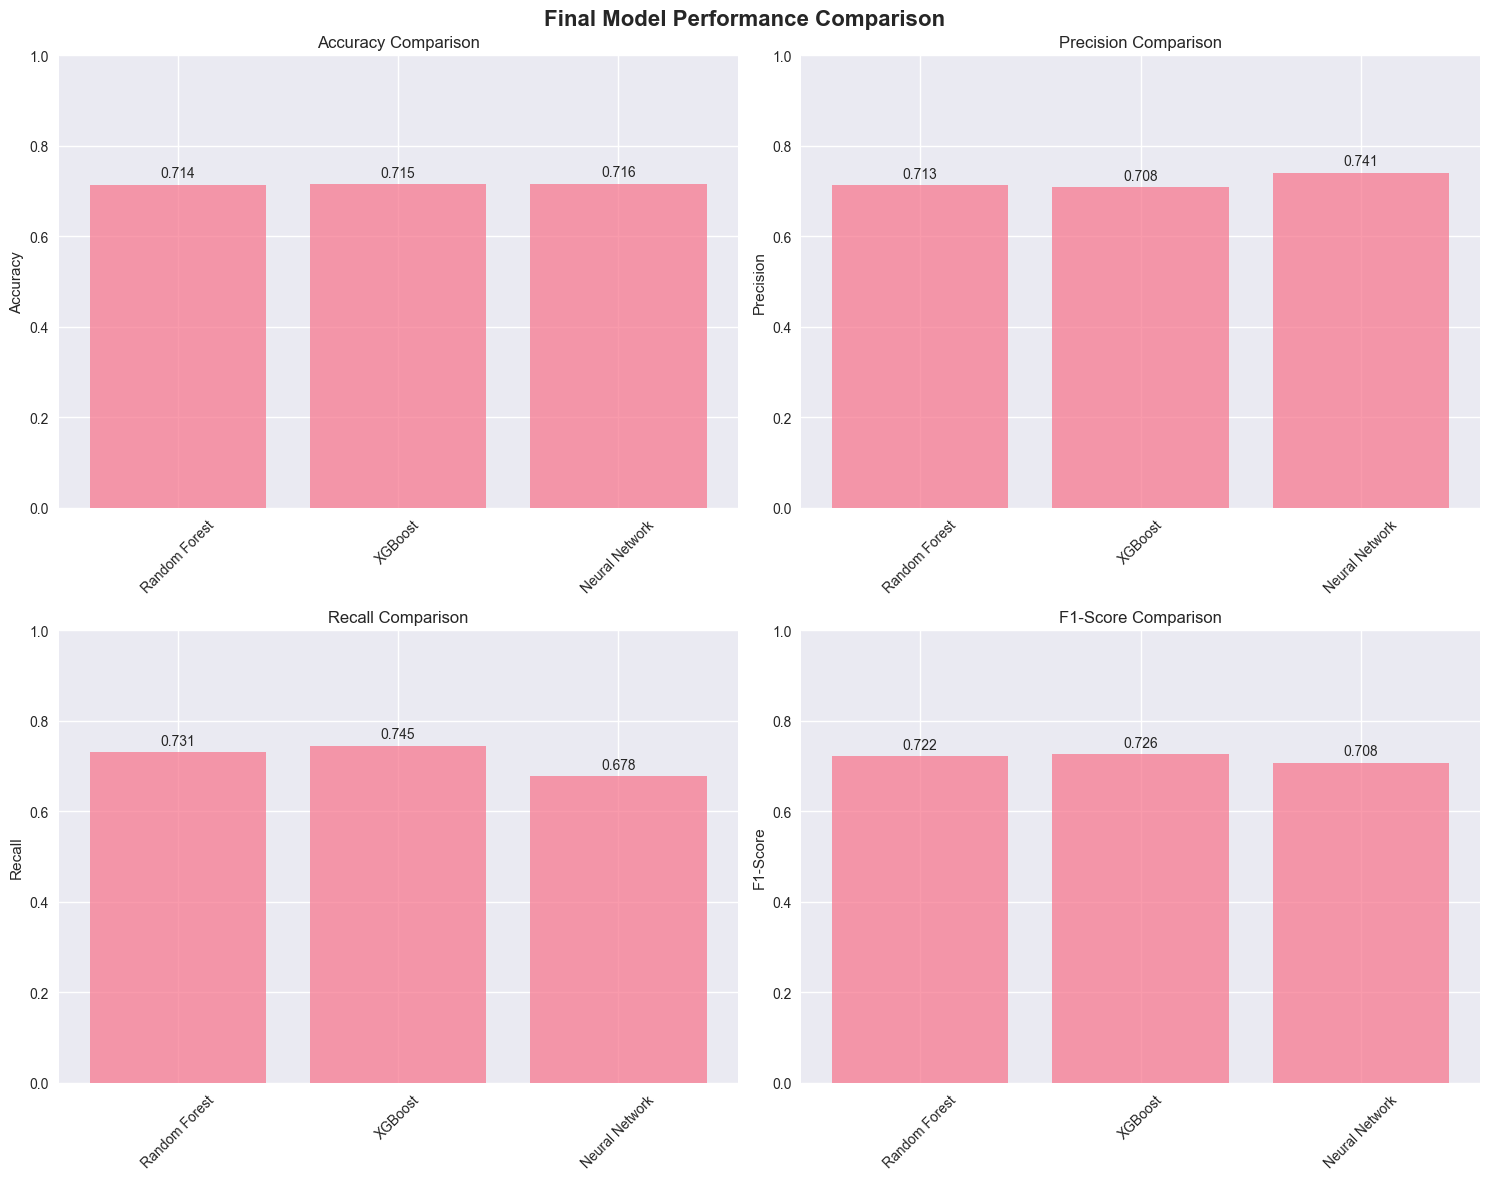


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
----------------------------------------
                             Random Forest  XGBoost  average
watch_percentage                    0.2950   0.1853   0.2402
watched_significant_portion         0.0117   0.4646   0.2382
watch_completion_rate               0.2541   0.1838   0.2190
minutes_watched                     0.2058   0.0575   0.1317
rating_movie                        0.0163   0.0078   0.0121
movie_vote_average                  0.0138   0.0101   0.0120
vote_average                        0.0144   0.0094   0.0119
movie_vote_count                    0.0129   0.0050   0.0090
vote_count                          0.0127   0.0052   0.0090
movie_popularity                    0.0134   0.0030   0.0082
genre_match_score                   0.0095   0.0065   0.0080
popularity                          0.0130   0.0027   0.0079
avg_daily_watch_time                0.0104   0.0032   0.0068
account_age_months                  0.0103 

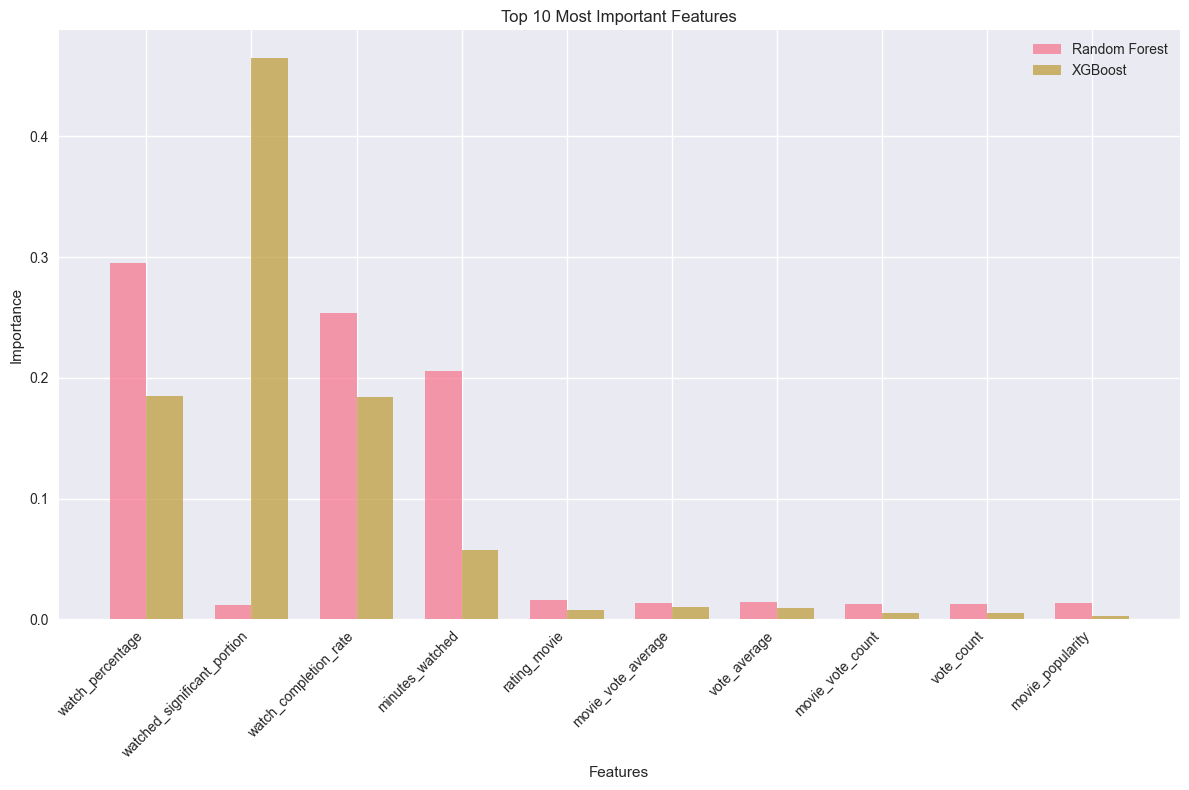


FINAL MODEL COMPARISON
                accuracy  precision  recall      f1     auc
Random Forest     0.7138     0.7126  0.7308  0.7216  0.7874
XGBoost           0.7145     0.7079  0.7448  0.7259  0.7882
Neural Network    0.7159     0.7406  0.6775  0.7077  0.7809


In [47]:
# Final model evaluation on test set
def evaluate_final_models(tuned_models, feature_sets, best_feature_set, y_test):
    """Evaluate tuned models on test set"""
    
    print("FINAL MODEL EVALUATION ON TEST SET")
    print("="*50)
    
    X_test_best = feature_sets[best_feature_set]['X_test']
    
    final_results = {}
    
    for model_name, model in tuned_models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Predictions
        y_test_pred = model.predict(X_test_best)
        y_test_proba = model.predict_proba(X_test_best)[:, 1]
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_proba)
        
        final_results[model_name] = {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'auc': test_auc
        }
        
        print(f"  Accuracy:  {test_accuracy:.4f}")
        print(f"  Precision: {test_precision:.4f}")
        print(f"  Recall:    {test_recall:.4f}")
        print(f"  F1-Score:  {test_f1:.4f}")
        print(f"  ROC-AUC:   {test_auc:.4f}")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"  Confusion Matrix:")
        print(f"    TN: {cm[0,0]:5d}  FP: {cm[0,1]:5d}")
        print(f"    FN: {cm[1,0]:5d}  TP: {cm[1,1]:5d}")
    
    return final_results

def create_comparison_visualization(final_results):
    """Create visualization comparing final model performance"""
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(final_results).T
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Final Model Performance Comparison', fontsize=16, fontweight='bold')
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        bars = ax.bar(comparison_df.index, comparison_df[metric], alpha=0.7)
        ax.set_title(f'{title} Comparison')
        ax.set_ylabel(title)
        ax.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')
        
        # Rotate x-axis labels if needed
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

def analyze_feature_importance(tuned_models, feature_sets, best_feature_set):
    """Analyze feature importance from the best model"""
    
    print("\nFEATURE IMPORTANCE ANALYSIS")
    print("="*40)
    
    features = feature_sets[best_feature_set]['features']
    
    # Get feature importance from Random Forest and XGBoost
    importance_data = {}
    
    if 'Random Forest' in tuned_models:
        rf_model = tuned_models['Random Forest']
        if hasattr(rf_model, 'feature_importances_'):
            importance_data['Random Forest'] = rf_model.feature_importances_
    
    if 'XGBoost' in tuned_models:
        xgb_model = tuned_models['XGBoost']
        if hasattr(xgb_model, 'feature_importances_'):
            importance_data['XGBoost'] = xgb_model.feature_importances_
    
    # Create feature importance DataFrame
    if importance_data:
        importance_df = pd.DataFrame(importance_data, index=features)
        importance_df['average'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('average', ascending=False)
        
        print("\nTop 15 Most Important Features:")
        print("-" * 40)
        print(importance_df.head(15).round(4))
        
        # Visualize top features
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(10)
        
        if len(importance_data) > 1:
            x = np.arange(len(top_features))
            width = 0.35
            
            plt.bar(x - width/2, top_features[list(importance_data.keys())[0]], 
                   width, label=list(importance_data.keys())[0], alpha=0.7)
            plt.bar(x + width/2, top_features[list(importance_data.keys())[1]], 
                   width, label=list(importance_data.keys())[1], alpha=0.7)
        else:
            plt.bar(range(len(top_features)), top_features.iloc[:, 0], alpha=0.7)
        
        plt.title('Top 10 Most Important Features')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right')
        if len(importance_data) > 1:
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print("No feature importance available for the models.")
        return None

# Run final evaluation
final_results = evaluate_final_models(tuned_models, feature_sets, best_feature_set, y_test)

# Create comparison visualization
comparison_df = create_comparison_visualization(final_results)

# Analyze feature importance
feature_importance_df = analyze_feature_importance(tuned_models, feature_sets, best_feature_set)

print(f"\n{'='*60}")
print("FINAL MODEL COMPARISON")
print(f"{'='*60}")
print(comparison_df.round(4))